In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
Configurations={}
Configurations["device"] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(Configurations["device"])

cuda


In [ ]:
Configurations["transform"] = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
batch_size = 4
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=Configurations["transform"])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=Configurations["transform"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_chk=torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Use all three channels for the classification

In [ ]:
sample_data = iter(train_loader)
image,_ = sample_data.next()
print(image.shape)

torch.Size([4, 3, 32, 32])


In [ ]:
def model_train(model,learning_Rate,num_epochs):
    Accuracy=[]
    ep=[]
    criterion = nn.CrossEntropyLoss()
    #Use SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(Configurations["device"])
            labels = labels.to(Configurations["device"])         
            outputs = model(images)
           
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 2000 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        n_samples=0
        n_correct=0
        for images, labels in train_loader:
            images = images.to(Configurations["device"])
            labels = labels.to(Configurations["device"])
            output=model(images)
            _, predicted = torch.max(output, 1)
            
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        print("Training Accuracy - ",acc)
        Accuracy.append(acc)
        ep.append(epoch)

    print('Finished Training')
    PATH = './cnn.pth'
    torch.save(model.state_dict(), PATH)
    return model,Accuracy,ep


def result_prediction(model):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for images, labels in test_loader:
            images = images.to(Configurations["device"])
            labels = labels.to(Configurations["device"])
            outputs = model(images)
            # max returns (value ,index)
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            for i in range(batch_size):
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc1 = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc1} %')

        for i in range(10):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
    return acc1


### 3(A) No BatchNormalization

In [ ]:
class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        return x


In [ ]:
model1= ConvNet_1().to(Configurations["device"])
num_epochs = 20
learning_rate = 0.001
model1,Accuracy,ep =model_train(model1,learning_rate,num_epochs)

Epoch [1/20], Step [2000/12500], Loss: 2.2822
Epoch [1/20], Step [4000/12500], Loss: 2.0591
Epoch [1/20], Step [6000/12500], Loss: 2.7938
Epoch [1/20], Step [8000/12500], Loss: 1.8755
Epoch [1/20], Step [10000/12500], Loss: 2.0620
Epoch [1/20], Step [12000/12500], Loss: 1.8289
Training Accuracy -  37.97
Epoch [2/20], Step [2000/12500], Loss: 1.4195
Epoch [2/20], Step [4000/12500], Loss: 1.6661
Epoch [2/20], Step [6000/12500], Loss: 1.2767
Epoch [2/20], Step [8000/12500], Loss: 1.7242
Epoch [2/20], Step [10000/12500], Loss: 1.6314
Epoch [2/20], Step [12000/12500], Loss: 1.8307
Training Accuracy -  45.422
Epoch [3/20], Step [2000/12500], Loss: 2.0757
Epoch [3/20], Step [4000/12500], Loss: 2.1107
Epoch [3/20], Step [6000/12500], Loss: 1.3104
Epoch [3/20], Step [8000/12500], Loss: 1.7293
Epoch [3/20], Step [10000/12500], Loss: 1.1137
Epoch [3/20], Step [12000/12500], Loss: 0.8983
Training Accuracy -  49.936
Epoch [4/20], Step [2000/12500], Loss: 0.8570
Epoch [4/20], Step [4000/12500], Loss

#### Save the best model and show accuracy on test data

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
model1_acc=result_prediction(model1)
PATH = './model_conv_1.pth'
torch.save(model1.state_dict(), PATH)

Accuracy of the network: 62.1 %
Accuracy of plane: 77.8 %
Accuracy of car: 79.0 %
Accuracy of bird: 54.5 %
Accuracy of cat: 42.7 %
Accuracy of deer: 49.6 %
Accuracy of dog: 42.4 %
Accuracy of frog: 76.5 %
Accuracy of horse: 65.3 %
Accuracy of ship: 66.3 %
Accuracy of truck: 66.9 %


#### plot the accuracy vs epoch

Text(0, 0.5, 'Accuracy')

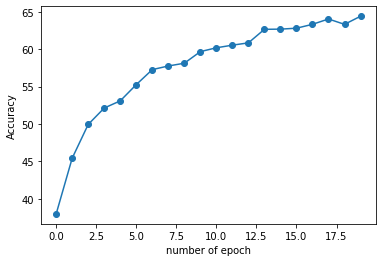

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ep,Accuracy)
plt.plot(ep,Accuracy)
plt.xlabel('number of epoch')
plt.ylabel('Accuracy')

#### Show the model architecture using model

In [ ]:
print(model)

ConvNet_1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)


### 3(B) Two Dense Layers. (Note: The last Dense layer should have 10 nodes as there are 10 classes. For the Dense layer before that, use 64 nodes.)

In [ ]:
class ConvNet_2(nn.Module):
    def __init__(self):
        super(ConvNet_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  #in_channels, out_channels(no of filters), kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5,64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)  # -> n, 400
        x = F.relu(self.fc1(x))  # -> n, 120
        x = self.fc2(x)  # -> n, 10
        return x


In [ ]:
model2= ConvNet_2().to(Configurations["device"])
num_epochs = 20
learning_rate = 0.001
model2,Accuracy2,ep2 =model_train(model2,learning_rate,num_epochs)

Epoch [1/20], Step [2000/12500], Loss: 2.2878
Epoch [1/20], Step [4000/12500], Loss: 2.3712
Epoch [1/20], Step [6000/12500], Loss: 2.6233
Epoch [1/20], Step [8000/12500], Loss: 2.4352
Epoch [1/20], Step [10000/12500], Loss: 2.0255
Epoch [1/20], Step [12000/12500], Loss: 1.2380
Training Accuracy -  31.966
Epoch [2/20], Step [2000/12500], Loss: 1.5384
Epoch [2/20], Step [4000/12500], Loss: 1.6742
Epoch [2/20], Step [6000/12500], Loss: 0.9370
Epoch [2/20], Step [8000/12500], Loss: 0.9344
Epoch [2/20], Step [10000/12500], Loss: 1.9180
Epoch [2/20], Step [12000/12500], Loss: 1.3689
Training Accuracy -  41.606
Epoch [3/20], Step [2000/12500], Loss: 2.3333
Epoch [3/20], Step [4000/12500], Loss: 1.5725
Epoch [3/20], Step [6000/12500], Loss: 1.4575
Epoch [3/20], Step [8000/12500], Loss: 1.5734
Epoch [3/20], Step [10000/12500], Loss: 1.1567
Epoch [3/20], Step [12000/12500], Loss: 0.8516
Training Accuracy -  47.54
Epoch [4/20], Step [2000/12500], Loss: 1.5811
Epoch [4/20], Step [4000/12500], Loss

#### Save the best model and show accuracy on test data

In [ ]:
model2_acc=result_prediction(model2)
PATH = './model_conv_2.pth'
torch.save(model2.state_dict(), PATH)

Accuracy of the network: 62.25 %
Accuracy of plane: 59.8 %
Accuracy of car: 76.2 %
Accuracy of bird: 51.1 %
Accuracy of cat: 49.4 %
Accuracy of deer: 57.0 %
Accuracy of dog: 44.8 %
Accuracy of frog: 68.0 %
Accuracy of horse: 67.1 %
Accuracy of ship: 85.2 %
Accuracy of truck: 63.9 %


#### plot the accuracy vs epoch

Text(0, 0.5, 'Accuracy')

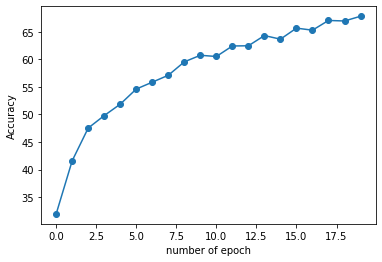

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(ep2,Accuracy2)
plt.plot(ep2,Accuracy2)
plt.xlabel('number of epoch')
plt.ylabel('Accuracy')

#### Show the model architecture using model

In [ ]:
print(model2)

ConvNet_2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


### 3(C) 2 blocks of Conv2D -> BatchNorm2D->MaxPooling2D

In [ ]:
class ConvNet_3(nn.Module):
    def __init__(self):
        super(ConvNet_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  #in_channels, out_channels(no of filters), kernel_size
        self.batch1=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5,10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.batch1(self.pool(F.relu(self.conv1(x))))  # -> n, 6, 14, 14
        x = self.batch2(self.pool(F.relu(self.conv2(x))))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)  # -> n, 400
        x = self.fc1(x) 
        return x

In [ ]:
model3= ConvNet_3().to(Configurations["device"])
num_epochs = 20
learning_rate = 0.001
model3,Accuracy3,ep3 =model_train(model3,learning_rate,num_epochs)

Epoch [1/20], Step [2000/12500], Loss: 2.3015
Epoch [1/20], Step [4000/12500], Loss: 0.9027
Epoch [1/20], Step [6000/12500], Loss: 1.2152
Epoch [1/20], Step [8000/12500], Loss: 1.7988
Epoch [1/20], Step [10000/12500], Loss: 2.1620
Epoch [1/20], Step [12000/12500], Loss: 0.6831
Training Accuracy -  49.502
Epoch [2/20], Step [2000/12500], Loss: 1.8857
Epoch [2/20], Step [4000/12500], Loss: 1.3752
Epoch [2/20], Step [6000/12500], Loss: 1.2616
Epoch [2/20], Step [8000/12500], Loss: 0.6323
Epoch [2/20], Step [10000/12500], Loss: 2.6077
Epoch [2/20], Step [12000/12500], Loss: 0.9265
Training Accuracy -  52.672
Epoch [3/20], Step [2000/12500], Loss: 1.2943
Epoch [3/20], Step [4000/12500], Loss: 0.9794
Epoch [3/20], Step [6000/12500], Loss: 0.5742
Epoch [3/20], Step [8000/12500], Loss: 1.6425
Epoch [3/20], Step [10000/12500], Loss: 1.2821
Epoch [3/20], Step [12000/12500], Loss: 2.0891
Training Accuracy -  57.068
Epoch [4/20], Step [2000/12500], Loss: 1.7138
Epoch [4/20], Step [4000/12500], Los

#### Save the best model and show accuracy on test data

In [ ]:
model3_acc=result_prediction(model3)
PATH = './model_conv_3.pth'
torch.save(model3.state_dict(), PATH)

Accuracy of the network: 59.59 %
Accuracy of plane: 62.7 %
Accuracy of car: 73.2 %
Accuracy of bird: 47.2 %
Accuracy of cat: 35.6 %
Accuracy of deer: 50.7 %
Accuracy of dog: 50.8 %
Accuracy of frog: 69.6 %
Accuracy of horse: 64.7 %
Accuracy of ship: 70.8 %
Accuracy of truck: 70.6 %


#### plot the accuracy vs epoch

Text(0, 0.5, 'Accuracy')

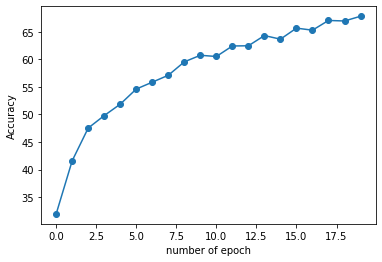

In [ ]:
plt.scatter(ep3,Accuracy3)
plt.plot(ep3,Accuracy3)
plt.xlabel('number of epoch')
plt.ylabel('Accuracy')

#### Show the model architecture using model

In [ ]:
print(model3)

ConvNet_3(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)


## 3(D) 3 blocks of Conv2D -> BatchNorm2D->MaxPooling2D

In [ ]:
class ConvNet_4(nn.Module):
    def __init__(self):
        super(ConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)  #in_channels, out_channels(no of filters), kernel_size
        self.batch1=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.batch2=nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.batch3=nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 3 * 3,10)
        

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.batch1(self.pool(F.relu(self.conv1(x))))  
        x = self.batch2(self.pool(F.relu(self.conv2(x))))  
        x = self.batch3(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 32 * 3 * 3)  
        x = self.fc1(x) 
        return x

In [ ]:
model4= ConvNet_4().to(Configurations["device"])
num_epochs = 20
learning_rate = 0.001
model4,Accuracy4,ep4 =model_train(model4,learning_rate,num_epochs)

Epoch [1/20], Step [2000/12500], Loss: 1.4405
Epoch [1/20], Step [4000/12500], Loss: 1.8403
Epoch [1/20], Step [6000/12500], Loss: 1.5712
Epoch [1/20], Step [8000/12500], Loss: 1.8893
Epoch [1/20], Step [10000/12500], Loss: 1.8282
Epoch [1/20], Step [12000/12500], Loss: 2.1381
Training Accuracy -  50.804
Epoch [2/20], Step [2000/12500], Loss: 0.8552
Epoch [2/20], Step [4000/12500], Loss: 2.2469
Epoch [2/20], Step [6000/12500], Loss: 1.8417
Epoch [2/20], Step [8000/12500], Loss: 1.0358
Epoch [2/20], Step [10000/12500], Loss: 0.9259
Epoch [2/20], Step [12000/12500], Loss: 1.2806
Training Accuracy -  55.598
Epoch [3/20], Step [2000/12500], Loss: 0.9889
Epoch [3/20], Step [4000/12500], Loss: 0.5969
Epoch [3/20], Step [6000/12500], Loss: 0.9235
Epoch [3/20], Step [8000/12500], Loss: 1.2528
Epoch [3/20], Step [10000/12500], Loss: 1.1508
Epoch [3/20], Step [12000/12500], Loss: 1.1876
Training Accuracy -  57.346
Epoch [4/20], Step [2000/12500], Loss: 1.9540
Epoch [4/20], Step [4000/12500], Los

#### Save the best model and show accuracy on test data

In [ ]:
model4_acc=result_prediction(model4)
PATH = './model_conv_4.pth'
torch.save(model4.state_dict(), PATH)

Accuracy of the network: 61.54 %
Accuracy of plane: 65.6 %
Accuracy of car: 75.0 %
Accuracy of bird: 43.2 %
Accuracy of cat: 42.6 %
Accuracy of deer: 60.4 %
Accuracy of dog: 50.0 %
Accuracy of frog: 69.6 %
Accuracy of horse: 64.6 %
Accuracy of ship: 73.2 %
Accuracy of truck: 71.2 %


#### plot the accuracy vs epoch

Text(0, 0.5, 'Accuracy')

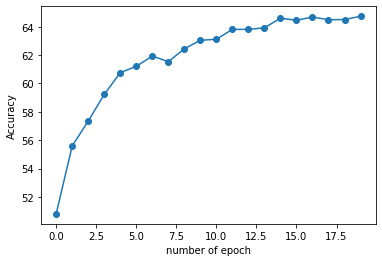

In [ ]:
plt.scatter(ep4,Accuracy4)
plt.plot(ep4,Accuracy4)
plt.xlabel('number of epoch')
plt.ylabel('Accuracy')

#### Show the model architecture using model

In [ ]:
print(model4)

ConvNet_4(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (batch3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=288, out_features=10, bias=True)
)


# ANALYSIS

In [ ]:
print("MODEL:")
print("PART A - No BatchNormalization")
print("PART B - Two Dense Layers")
print("PART C - 2 blocks of Conv2D -> BatchNorm2D -> MaxPooling2D")
print("PART D - 3 blocks of Conv2D -> BatchNorm2D -> MaxPooling2D")
table = [['MODEL', 'ACCURACY'], ['PART A',str(model1_acc)+"%"], ['PART B',str(model2_acc)+"%"], ['PART C',str(model3_acc)+"%"], ['PART D',str(model4_acc)+"%"]]

print()
print()
from tabulate import tabulate
print(tabulate(table, headers='firstrow'))

MODEL:
PART A - No BatchNormalization
PART B - Two Dense Layers
PART C - 2 blocks of Conv2D -> BatchNorm2D -> MaxPooling2D
PART D - 3 blocks of Conv2D -> BatchNorm2D -> MaxPooling2D


MODEL    ACCURACY
-------  ----------
PART A   62.1%
PART B   62.25%
PART C   59.59%
PART D   61.54%
